In [22]:
# If running locally
!pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable


In [23]:
import sys
sys.path.append(".")

from src.data.cmems_dataset import load_cmems_uv, SlidingWindowUVDataset
from src.models.unet_convlstm_unc import UNetConvLSTMUncertainty, gaussian_nll


In [24]:
import numpy as np

In [ ]:
data_path = "/home/svillhauer/Desktop/Thesis/Currents/deep_spatiotemporal_currents/src/data/cmems_mod_glo_phy_anfc_merged-uv_PT1H-i_1770985217793.nc"

uv, time, lat, lon = load_cmems_uv(
    data_path,
    u_var="utotal",
    v_var="vtotal",
    depth_index=0,
    regrid_hw=(64,64)   # optional but recommended
)

print(uv.shape)  # (T,2,H,W)


(1045, 2, 64, 64)


In [26]:
# from src.data.cmems_dataset import compute_minmax, apply_minmax

seq_len = 3

split_t = int(len(uv)*0.7)
uv_train = uv[:split_t]
uv_val = uv[split_t:]

# stats = compute_minmax(uv_train)
# uv_train_n = apply_minmax(uv_train, stats)
# uv_val_n = apply_minmax(uv_val, stats)

# train_ds = SlidingWindowUVDataset(uv_train_n, seq_len=seq_len)
# val_ds   = SlidingWindowUVDataset(uv_val_n,   seq_len=seq_len)


In [ ]:

class ZScoreStats:
    def __init__(self, u_mean, u_std, v_mean, v_std):
        self.u_mean = u_mean
        self.u_std = u_std
        self.v_mean = v_mean
        self.v_std = v_std

def compute_zscore(uv):
    # uv: (T,2,H,W)
    u = uv[:,0]
    v = uv[:,1]

    u_mean = np.mean(u)
    u_std  = np.std(u) + 1e-8
    v_mean = np.mean(v)
    v_std  = np.std(v) + 1e-8

    return ZScoreStats(u_mean, u_std, v_mean, v_std)

def apply_zscore(uv, stats):
    uv_n = uv.copy()
    uv_n[:,0] = (uv_n[:,0] - stats.u_mean) / stats.u_std
    uv_n[:,1] = (uv_n[:,1] - stats.v_mean) / stats.v_std
    return uv_n


In [28]:
stats = compute_zscore(uv_train)
uv_train_n = apply_zscore(uv_train, stats)
uv_val_n   = apply_zscore(uv_val, stats)

train_ds = SlidingWindowUVDataset(uv_train_n, seq_len=seq_len)
val_ds   = SlidingWindowUVDataset(uv_val_n,   seq_len=seq_len)

In [ ]:
# import torch
# from torch.utils.data import DataLoader

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
# val_loader   = DataLoader(val_ds, batch_size=4)

# # Uncertainty model outputs (mu, logvar) where each is (B,2,H,W)
# model = UNetConvLSTMUncertainty(base_ch=32, lstm_ch=256).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# def rmse(a,b): 
#     return torch.sqrt(torch.mean((a-b)**2))

# epochs = 10000

# for epoch in range(epochs):
#     model.train()
#     train_loss = 0.0

#     for X,Y in train_loader:
#         X,Y = X.to(device), Y.to(device)

#         mu, logvar = model(X)
#         loss = gaussian_nll(mu, logvar, Y)

#         opt.zero_grad(set_to_none=True)
#         loss.backward()
#         opt.step()

#         train_loss += loss.item()

#     model.eval()
#     val_rmse = 0.0
#     with torch.no_grad():
#         for X,Y in val_loader:
#             X,Y = X.to(device), Y.to(device)
#             mu, logvar = model(X)
#             val_rmse += rmse(mu, Y).item()

#     print(f"Epoch {epoch}: train_nll={train_loss:.4f}  val_rmse={val_rmse:.4f}")


Epoch 0: train_nll=182.9144  val_rmse=43.5027
Epoch 1: train_nll=-46.1766  val_rmse=25.9677
Epoch 2: train_nll=-158.6506  val_rmse=23.8791
Epoch 3: train_nll=-181.4426  val_rmse=19.3599
Epoch 4: train_nll=-212.1470  val_rmse=18.9514
Epoch 5: train_nll=-218.4660  val_rmse=17.2353
Epoch 6: train_nll=-143.8602  val_rmse=78.7628
Epoch 7: train_nll=146.6099  val_rmse=34.4395
Epoch 8: train_nll=-98.3627  val_rmse=20.7799
Epoch 9: train_nll=-143.5540  val_rmse=22.6917
Epoch 10: train_nll=-176.8925  val_rmse=20.4615
Epoch 11: train_nll=-204.8115  val_rmse=17.9921
Epoch 12: train_nll=-214.4101  val_rmse=16.3479
Epoch 13: train_nll=-221.3032  val_rmse=16.3196
Epoch 14: train_nll=-232.6527  val_rmse=16.3933
Epoch 15: train_nll=-241.0478  val_rmse=14.9764
Epoch 16: train_nll=-253.8916  val_rmse=15.5220
Epoch 17: train_nll=-258.7681  val_rmse=14.6518
Epoch 18: train_nll=-264.2826  val_rmse=15.8173
Epoch 19: train_nll=-259.8669  val_rmse=16.2258
Epoch 20: train_nll=-273.9261  val_rmse=14.7564
Epoch 

KeyboardInterrupt: 

In [34]:
import os
import torch
from torch.utils.data import DataLoader
import json

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)

# ---- Model + optimizer ----
model = UNetConvLSTMUncertainty(base_ch=32, lstm_ch=256).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

def rmse(a, b):
    return torch.sqrt(torch.mean((a - b) ** 2))

# ---- Where to save ----
run_dir = "runs/convlstm_unc"
os.makedirs(run_dir, exist_ok=True)
best_path  = os.path.join(run_dir, "best.pt")
final_path = os.path.join(run_dir, "final.pt")

best_val_rmse = float("inf")
epochs = 500

history = []
history_path = os.path.join(run_dir, "history.json")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


for epoch in range(epochs):
    # -------- Train --------
    model.train()
    train_loss_sum = 0.0
    n_train = 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)

        mu, logvar = model(X)
        loss = gaussian_nll(mu, logvar, Y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        train_loss_sum += loss.item() * X.size(0)
        n_train += X.size(0)

    train_nll = train_loss_sum / max(n_train, 1)

    # -------- Validate --------
    model.eval()
    val_rmse_sum = 0.0
    n_val = 0

    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            mu, logvar = model(X)
            batch_rmse = rmse(mu, Y)

            val_rmse_sum += batch_rmse.item() * X.size(0)
            n_val += X.size(0)

    val_rmse_avg = val_rmse_sum / max(n_val, 1)

    print(f"Epoch {epoch:04d}: train_nll={train_nll:.6f}  val_rmse={val_rmse_avg:.6f}")

    # -------- Save best --------
    if val_rmse_avg < best_val_rmse:
        best_val_rmse = val_rmse_avg
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": opt.state_dict(),
                "best_val_rmse": best_val_rmse,
                # IMPORTANT: save normalization stats so you can de-normalize later
                "stats": stats.__dict__ if hasattr(stats, "__dict__") else stats,
                "seq_len": seq_len,
            },
            best_path,
        )
        print(f" Saved new best checkpoint -> {best_path}")

    # -------- Optional: periodic checkpoints --------
    if epoch > 0 and epoch % 25 == 0:
        ckpt_path = os.path.join(run_dir, f"checkpoint_epoch_{epoch}.pt")
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": opt.state_dict(),
                "val_rmse": val_rmse_avg,
                "stats": stats.__dict__ if hasattr(stats, "__dict__") else stats,
                "seq_len": seq_len,
            },
            ckpt_path,
        )
        print(f" Saved periodic checkpoint -> {ckpt_path}")

# ---- Save final model at the end ----
torch.save(
    {
        "epoch": epochs - 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
        "final_val_rmse": val_rmse_avg,
        "stats": stats.__dict__ if hasattr(stats, "__dict__") else stats,
        "seq_len": seq_len,
    },
    final_path,
)

print(f" Training done. Best val_rmse={best_val_rmse:.6f}")
print(f"Best checkpoint:  {best_path}")
print(f"Final checkpoint: {final_path}")

# -------- Save history --------
history.append({
    "epoch": int(epoch),
    "train_nll": float(train_nll),
    "val_rmse": float(val_rmse_avg),
    "lr": float(opt.param_groups[0]["lr"]),
})
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)



Epoch 0000: train_nll=0.006190  val_rmse=0.330672
 Saved new best checkpoint -> runs/convlstm_unc/best.pt
Epoch 0001: train_nll=-0.434914  val_rmse=0.468440
Epoch 0002: train_nll=2.340167  val_rmse=0.320835
 Saved new best checkpoint -> runs/convlstm_unc/best.pt
Epoch 0003: train_nll=-0.637645  val_rmse=0.266812
 Saved new best checkpoint -> runs/convlstm_unc/best.pt
Epoch 0004: train_nll=-0.980215  val_rmse=0.231487
 Saved new best checkpoint -> runs/convlstm_unc/best.pt
Epoch 0005: train_nll=-1.140719  val_rmse=0.221088
 Saved new best checkpoint -> runs/convlstm_unc/best.pt
Epoch 0006: train_nll=-1.208912  val_rmse=0.233551
Epoch 0007: train_nll=-1.291754  val_rmse=0.204745
 Saved new best checkpoint -> runs/convlstm_unc/best.pt
Epoch 0008: train_nll=-1.380503  val_rmse=0.194383
 Saved new best checkpoint -> runs/convlstm_unc/best.pt
Epoch 0009: train_nll=-1.278919  val_rmse=0.185751
 Saved new best checkpoint -> runs/convlstm_unc/best.pt
Epoch 0010: train_nll=-1.438857  val_rmse=0.

In [ ]:
# t = 100
# X = uv_val_n[t-seq_len:t]

# with torch.no_grad():
#     mu, logvar = model(torch.tensor(X[None]).to(device))
#     pred = mu.cpu().numpy()[0]                   # (2,H,W) mean prediction
#     sigma = torch.exp(0.5 * logvar).cpu().numpy()[0]  # (2,H,W) std-dev (normalized units)

# pred.shape, sigma.shape


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# u_pred, v_pred = pred
# speed = np.sqrt(u_pred**2 + v_pred**2)

# # uncertainty magnitude from per-channel sigma
# unc = np.sqrt(sigma[0]**2 + sigma[1]**2)

# plt.figure(figsize=(6,5))
# plt.imshow(speed)
# plt.colorbar(label="Predicted current speed (normalized)")
# plt.title("Predicted current field (mean)")
# plt.show()

# plt.figure(figsize=(6,5))
# plt.imshow(unc)
# plt.colorbar(label="Predicted σ magnitude (normalized)")
# plt.title("Uncertainty field")
# plt.show()


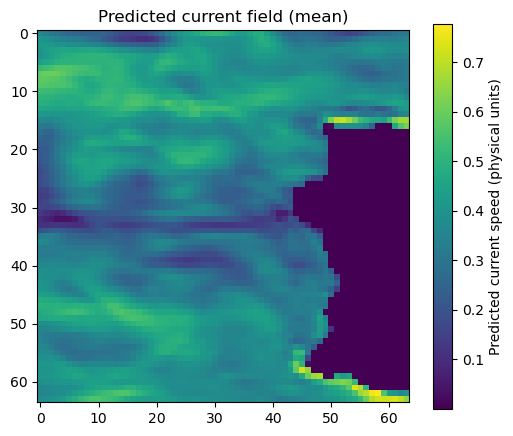

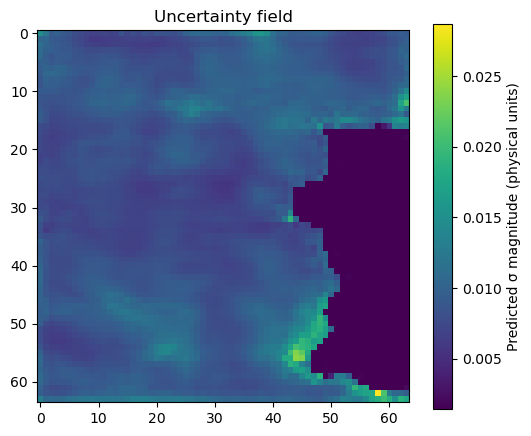

In [35]:
t = 100
X = uv_val_n[t-seq_len:t]   # still normalized inputs (z-score)

with torch.no_grad():
    mu, logvar = model(torch.tensor(X[None]).to(device))
    mu = mu.cpu().numpy()[0]                      # (2,H,W) mean (z-score units)
    sigma = torch.exp(0.5 * logvar).cpu().numpy()[0]  # (2,H,W) std-dev (z-score units)

# ---- de-normalize mean back to physical units ----
u_mu = mu[0] * stats.u_std + stats.u_mean
v_mu = mu[1] * stats.v_std + stats.v_mean

# ---- convert sigma to physical units ----
u_sigma = sigma[0] * stats.u_std
v_sigma = sigma[1] * stats.v_std

speed = np.sqrt(u_mu**2 + v_mu**2)
unc = np.sqrt(u_sigma**2 + v_sigma**2)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.imshow(speed)
plt.colorbar(label="Predicted current speed (physical units)")
plt.title("Predicted current field (mean)")
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(unc)
plt.colorbar(label="Predicted σ magnitude (physical units)")
plt.title("Uncertainty field")
plt.show()


Running on: cuda


NameError: name 'models' is not defined

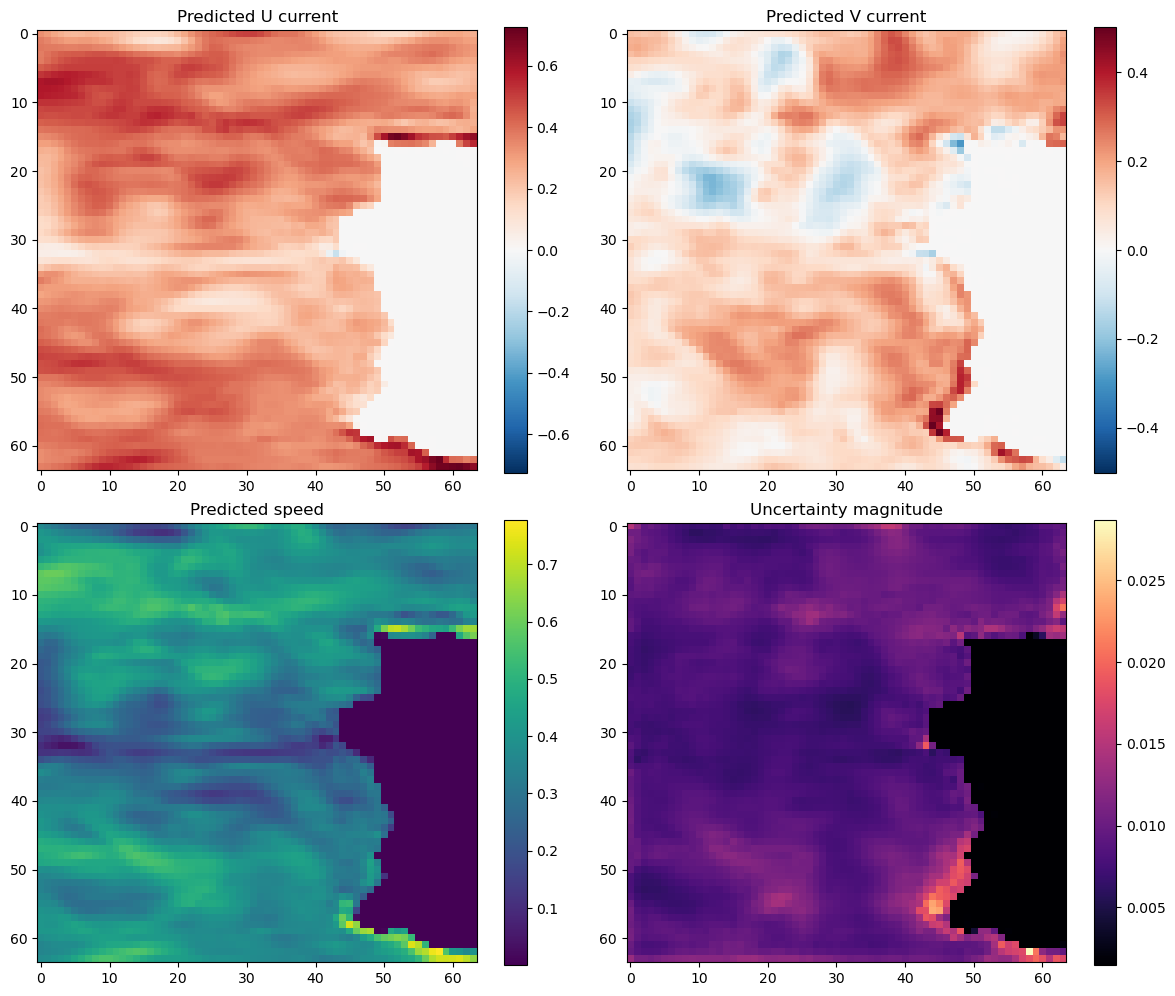

In [36]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ---- de-normalized u,v from earlier ----
# u_mu, v_mu, speed, unc already computed

# Diverging normalization centered at 0
u_lim = max(abs(u_mu.min()), abs(u_mu.max()))
v_lim = max(abs(v_mu.min()), abs(v_mu.max()))

u_norm = TwoSlopeNorm(vmin=-u_lim, vcenter=0, vmax=u_lim)
v_norm = TwoSlopeNorm(vmin=-v_lim, vcenter=0, vmax=v_lim)

fig, axes = plt.subplots(2,2, figsize=(12,10))

# ---- U component ----
im0 = axes[0,0].imshow(u_mu, cmap="RdBu_r", norm=u_norm)
axes[0,0].set_title("Predicted U current")
plt.colorbar(im0, ax=axes[0,0])

# ---- V component ----
im1 = axes[0,1].imshow(v_mu, cmap="RdBu_r", norm=v_norm)
axes[0,1].set_title("Predicted V current")
plt.colorbar(im1, ax=axes[0,1])

# ---- Speed (sequential) ----
im2 = axes[1,0].imshow(speed, cmap="viridis")
axes[1,0].set_title("Predicted speed")
plt.colorbar(im2, ax=axes[1,0])

# ---- Uncertainty magnitude ----
im3 = axes[1,1].imshow(unc, cmap="magma")
axes[1,1].set_title("Uncertainty magnitude")
plt.colorbar(im3, ax=axes[1,1])

plt.tight_layout()
plt.show()


### Notes on the uncertainty output
- `pred` is the **mean** current prediction (u,v).
- `sigma` is the **per-pixel standard deviation** (u,v) learned by the model (aleatoric uncertainty).
- `sigma` is currently in the **same normalized units** as training (because the model learns it in normalized space).  
  If you want `sigma` in physical units (m/s), we can convert it using your training min–max ranges.
